# クラスタリングを用いたアニメのレコメンドシステム

## 概要説明

機械学習技術を用いてユーザークラスタリングを行います。今回用いる機械学習アルゴリズムは以下の2つです。  

Scikit-learn: 
* PCA(主成分分析)
* K-means clustering

### プログラムのアウトライン
以下にプログラム全体のOutlineを示します。
1. データセットの読み込みと前処理
2. 主成分分析による次元の削減
3. k-mean法によるクラスタリング
4. 各クラスターの特徴の考察
5. レコメンド機能の実装

### 使用したデータセット
今回利用するデータセットについて説明します。「Anime Recommendations Database」という、myanimelist.netの76,000ユーザーのアニメのレビューデータを利用します。 このデータセットは「anime.csv」と「ratings.csv」の2つのCSVファイルにより構成されています。2つのCSVファイルの概要は下記の通りです。 このデータセットは下記のkaggleのページより入手できます。 https://www.kaggle.com/CooperUnion/anime-recommendations-database

### anime.csv概要
- anime_id  各アニメのユニークID
- name  アニメタイトル
- genre  アニメの属するカテゴリ
- type  メディアタイプ（例：映画、テレビetc）
- episodes  アニメのエピソード数
- rating  最大10の平均レーティング
- members  当該アニメのグループに参加するユーザー数

### ratings.csv概要
- user_id  ユニークユーザーID
- anime_id  当該ユーザーがレートしたアニメID
- rating  当該ユーザーのレーティング

### 今回工夫した点
- userごとにratingの平均を取り、その平均よりも高い評価をしているデータのみ分析に使用した点。今回はレコメンドシステムを見据えたクラスタリングであるため、低い評価をしたデータを省くことでレコメンド精度が高くなると考えました。
- クラスターの特徴を考える際に、アニメタイトルごとに特徴をまとめたリストをまず作成し、その後、クラスターに属するアニメタイトルの特徴をカウントアップしていく手法にした点。各クラスターには重複したアニメタイトルが見受けられた。プログラムの汎用性を考えたとき、クラスター数が増えたときにより早く処理をするためには、一度アニメタイトルごとに特徴をまとめたリストを作る方が処理が速くなると考えました。
- クラスターの特徴を考える際に、ワードクラウド画像を利用した点。より視覚的にクラスターの特徴を把握できると考えました。

# 1.データセットの読み込みと前処理

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3Da
%matplotlib inline

import numpy as np
import seaborn as sns
plt.rcParams['figure.figsize'] = (6, 4)
plt.style.use('ggplot')
%config InlineBackend.figure_formats = {'png', 'retina'}

In [2]:
# CSVファイルをデータフレーム形式として読み込み
anime = pd.read_csv('anime.csv')
print(anime.shape)
anime.head(1)

#約1.2万種類のアニメごとのジャンル、評価等のデータセットと思われる

(12294, 7)


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630


In [3]:
user = pd.read_csv('rating.csv')
print(user.shape)
user.head(1)

#約781万人のアニメごと評価のデータセットと思われる

(7813737, 3)


,user_id,anime_id,rating
0,1,20,-1


In [4]:
#userの中で、評価していない（rating=-1）のデータを削除する
print(len(user))
user = user[user['rating'] >= 0]
print(len(user))

# 781万のデータが633万に減った

7813737
6337241


In [5]:
# 欠損データの確認
anime.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [6]:
# データ総数と比較して欠損データは少ないため、除去する
anime = anime.dropna()

In [7]:
# 欠損データの確認
user.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [8]:
# データの俯瞰
anime.describe()

# countの値が揃っていることを確認

,anime_id,rating,members
count,12017.000000,12017.000000,1.201700e+04
mean,13638.001165,6.478264,1.834888e+04
std,11231.076675,1.023857,5.537250e+04
min,1.000000,1.670000,1.200000e+01
25%,3391.000000,5.890000,2.250000e+02
50%,9959.000000,6.570000,1.552000e+03
75%,23729.000000,7.180000,9.588000e+03
max,34519.000000,10.000000,1.013917e+06


In [9]:
# データの俯瞰
user.describe()

# countの値が揃っていることを確認

,user_id,anime_id,rating
count,6.337241e+06,6.337241e+06,6.337241e+06
mean,3.674791e+04,8.902866e+03,7.808497e+00
std,2.101340e+04,8.882000e+03,1.572496e+00
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.898400e+04,1.239000e+03,7.000000e+00
50%,3.681500e+04,6.213000e+03,8.000000e+00
75%,5.487300e+04,1.407500e+04,9.000000e+00
max,7.351600e+04,3.447500e+04,1.000000e+01


In [10]:
# 仮説：ユーザーごとに辛口評価の人、甘口評価の人がいるのではないか
# 上記仮説を確認してみる

for i in range(1,10):
    print(user[user['user_id'] == i].rating.mean())
    
# nanのセルはなくなっているはずなので、nanになっているのは該当するuser_idのデータがないということ
# やはり人によって評価の平均は大きく異なる場合がある

10.0
10.0
7.565217391304348
nan
4.355119825708061
nan
7.387755102040816
8.333333333333334
8.0


In [11]:
# user_idごとにratingの平均を算出する
MRPU = user.groupby(['user_id']).mean().reset_index()
MRPU['mean_rating'] = MRPU['rating']

MRPU.drop(['anime_id','rating'],axis=1, inplace=True)
MRPU.head(10)

,user_id,mean_rating
0,1,10.000000
1,2,10.000000
2,3,7.565217
3,5,4.355120
4,7,7.387755
5,8,8.333333
6,9,8.000000
7,10,9.333333
8,11,7.327273
9,12,8.818182


In [12]:
# user_idをkeyとして、userにMRPUをマージする
user = pd.merge(user,MRPU,on=['user_id','user_id'])
user.head(5)

,user_id,anime_id,rating,mean_rating
0,1,8074,10,10.0
1,1,11617,10,10.0
2,1,11757,10,10.0
3,1,15451,10,10.0
4,2,11771,10,10.0


In [13]:
# 今回はレコメンド機能の作成を想定しているため、評価の低いデータは除去する
user = user.drop(user[user.rating < user.mean_rating].index)
print(user.shape)

# 633万から338万のデータに減った

(3381057, 4)


In [14]:
# ためしに3人分のuserデータを見てみる
user[user['user_id']== 1].head(10)

# id 1 の人は4つのアニメ全てに10点をつけている

,user_id,anime_id,rating,mean_rating
0,1,8074,10,10.0
1,1,11617,10,10.0
2,1,11757,10,10.0
3,1,15451,10,10.0


In [15]:
user[user['user_id']== 2].head(10)

# id 2 の人は1つのアニメに10点をつけている

,user_id,anime_id,rating,mean_rating
4,2,11771,10,10.0


In [16]:
user[user['user_id']== 3].head(10)

# id 3 の人は10つ以上のアニメ全てに8~10点をつけている.平均は7.6.

,user_id,anime_id,rating,mean_rating
5,3,20,8,7.565217
7,3,170,9,7.565217
8,3,199,10,7.565217
9,3,225,9,7.565217
14,3,813,10,7.565217
18,3,1132,8,7.565217
20,3,1313,8,7.565217
22,3,1535,10,7.565217
24,3,1689,8,7.565217
26,3,1943,8,7.565217


In [17]:
# 何名分のデータなのか確認
len(user['user_id'].unique())

# 約7万人のデータがある

69600

In [18]:
# この後のdatasetの統合を見越して、カラム名を変更
user = user.rename({'rating':'userRating'}, axis='columns')

In [19]:
# 2つのデータセットをマージする
mergedata = pd.merge(anime,user,on=['anime_id','anime_id'])

print(mergedata.shape)
mergedata.head(1)

(3381039, 10)


,anime_id,name,genre,type,episodes,rating,members,user_id,userRating,mean_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,152,10,7.760563


In [20]:
# サイズの大きなデータセットなので、runtimeを考慮してデータサイズを減らす
mergedata= mergedata[mergedata.user_id <= 20000]
print(mergedata.shape)

(894525, 10)


In [21]:
# アニメの本数を確認
len(mergedata['anime_id'].unique())

7327

In [22]:
# 元データのアニメの本数を確認
len(anime['anime_id'].unique())

#　半分以上のアニメは残っていることがわかる。

12017

# 2.主成分分析による次元の削減

In [23]:
# 主成分分析による次元削減をするために、クロステーブルを作成する
# アニメのタイトルと、それぞれのユーザーの評価とのクロステーブルデータを作成

user_anime = pd.crosstab(mergedata['user_id'], mergedata['name'])
user_anime.head(5)

name,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,&quot;Eiji&quot;,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,...,gdgd Fairies Movie: tte Iu Eiga wa Dou kana...?,iDOLM@STER Xenoglossia,lilac (bombs Jun Togawa),makemagic,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
# datasizeの確認
user_anime.shape

(18890, 7327)

In [25]:
# 主成分分析を行う
# 主成分分析の目的は、次元の削減と、クラスタリングし、ビジュアライズすること。
# ビジュアライズするために、n_componentsの値は3とする
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(user_anime)
pca_samples = pca.transform(user_anime)

ps = pd.DataFrame(pca_samples)
ps.head()

# 3次元に削減できていることを確認

,0,1,2
0,-1.408696,-0.459659,0.348553
1,-1.577487,-0.214588,-0.005257
2,0.495043,-1.317133,-0.818168
3,3.739114,-0.358818,-0.481412
4,2.688737,-0.938413,0.964025


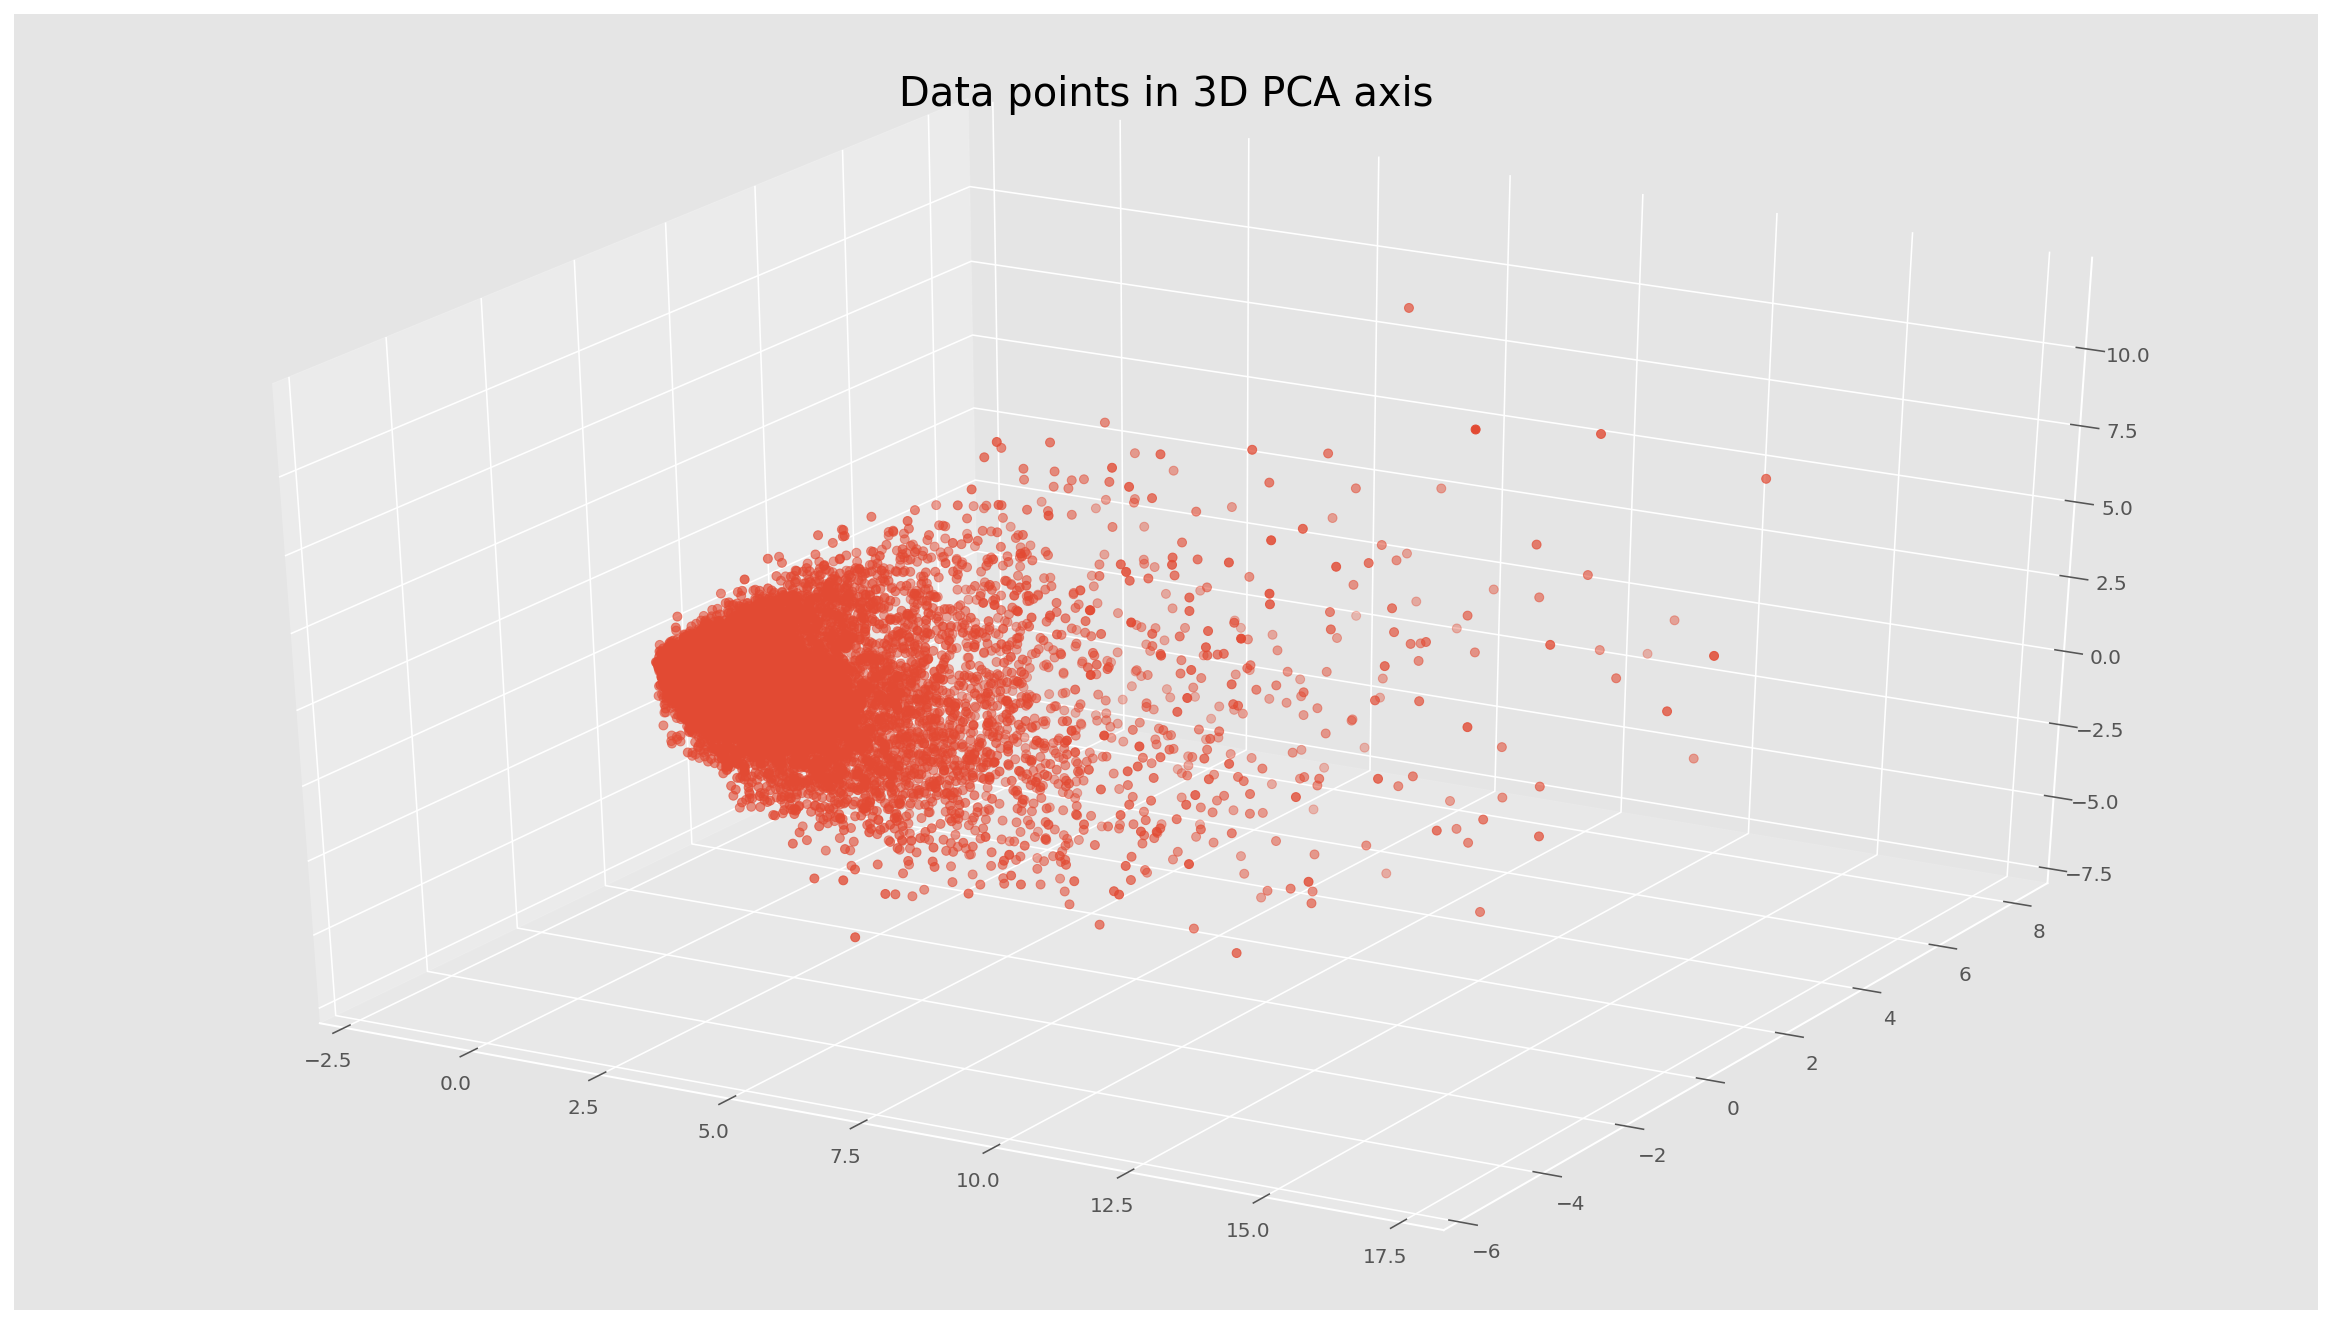

In [26]:
tocluster = ps

# 主成分3つの軸で3Dグラフを描画
plt.rcParams['figure.figsize'] = (16, 9)

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1])

plt.title('Data points in 3D PCA axis', fontsize=20)
plt.show()

# 3.k-mean法によるクラスタリング

In [27]:
# k-mean法によるクラスタリングを行う
# いくつのクラスに分類するか考える

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []
inertia_list = np.empty(8)

for i in range(2,8):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(tocluster)
    inertia_list[i] = kmeans.inertia_
    scores.append(silhouette_score(tocluster, kmeans.labels_))

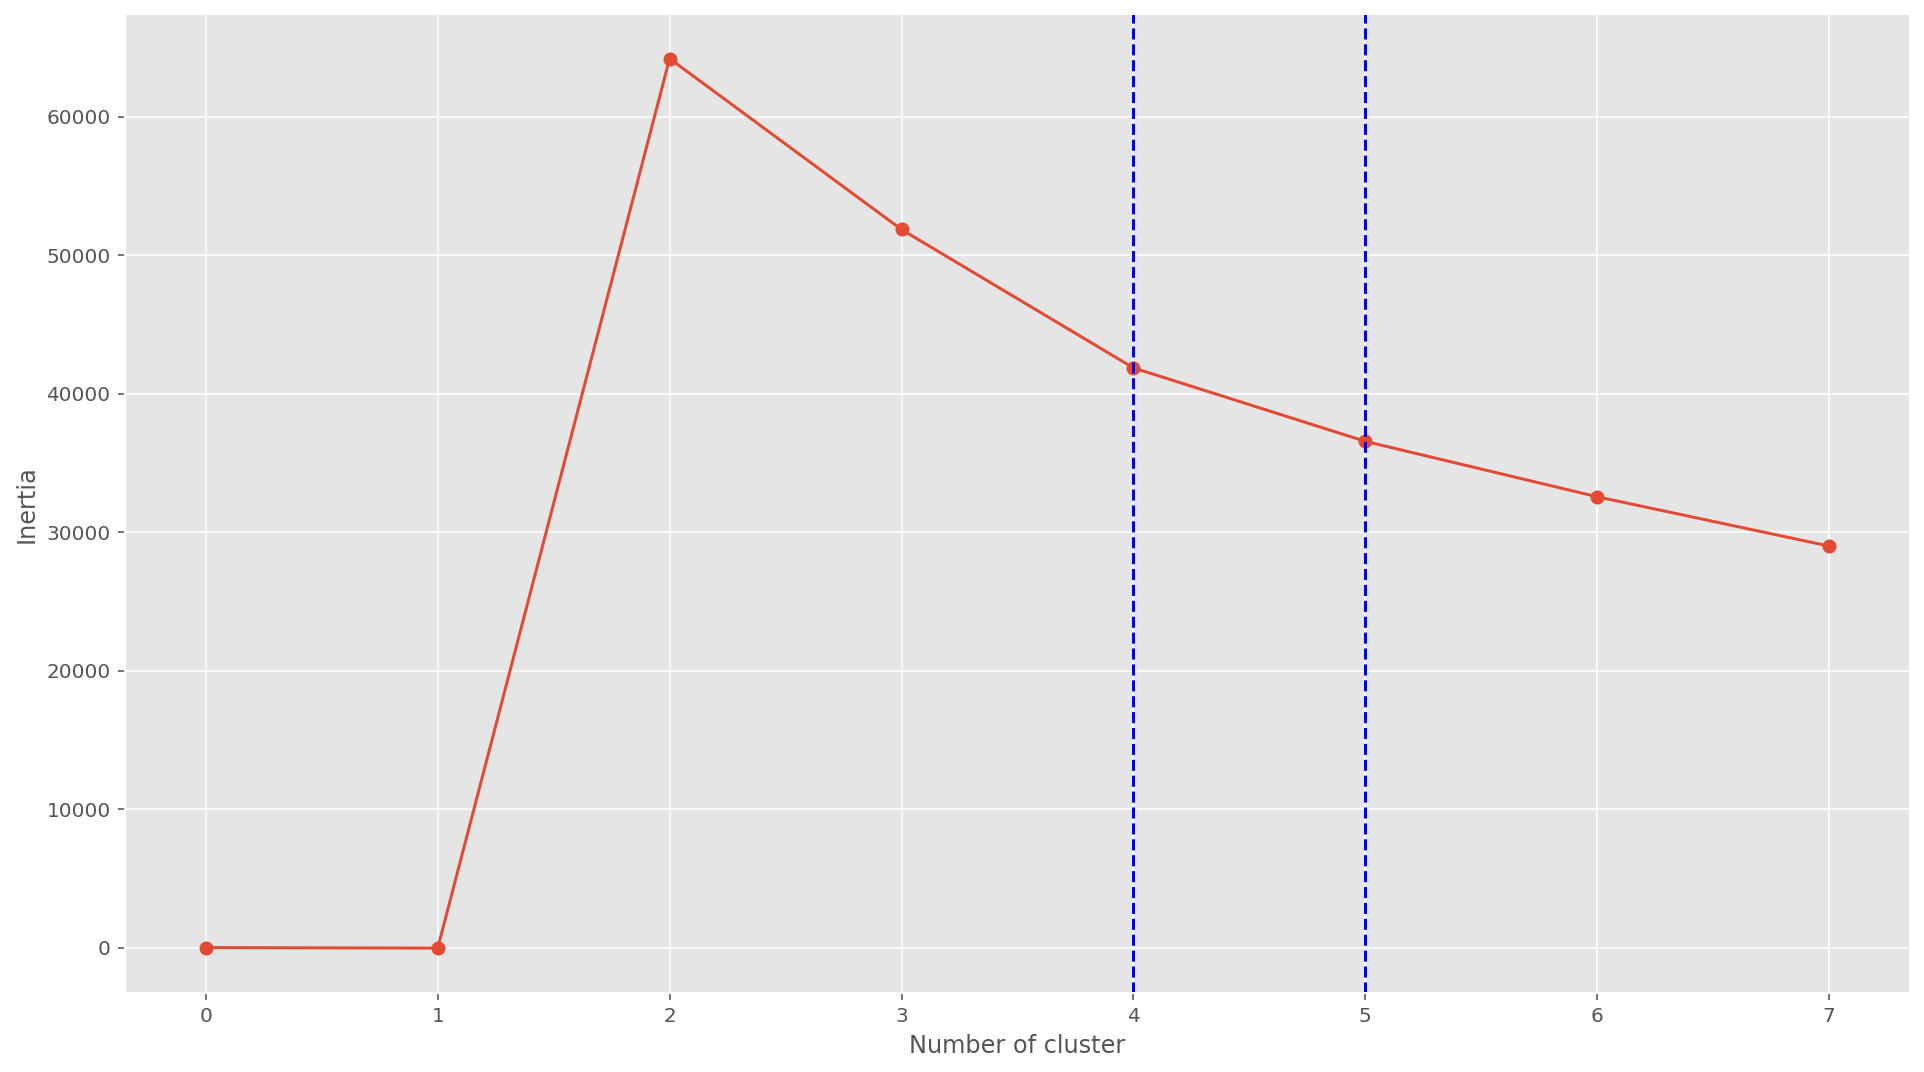

In [28]:
# エルボー法によってkの値を考える
plt.plot(range(0,8),inertia_list,'-o')
plt.xlabel('Number of cluster')
plt.axvline(x=4, color='blue', linestyle='--')
plt.axvline(x=5, color='blue', linestyle='--')
plt.ylabel('Inertia')
plt.show()

# k=4 or k=5 がよさそう

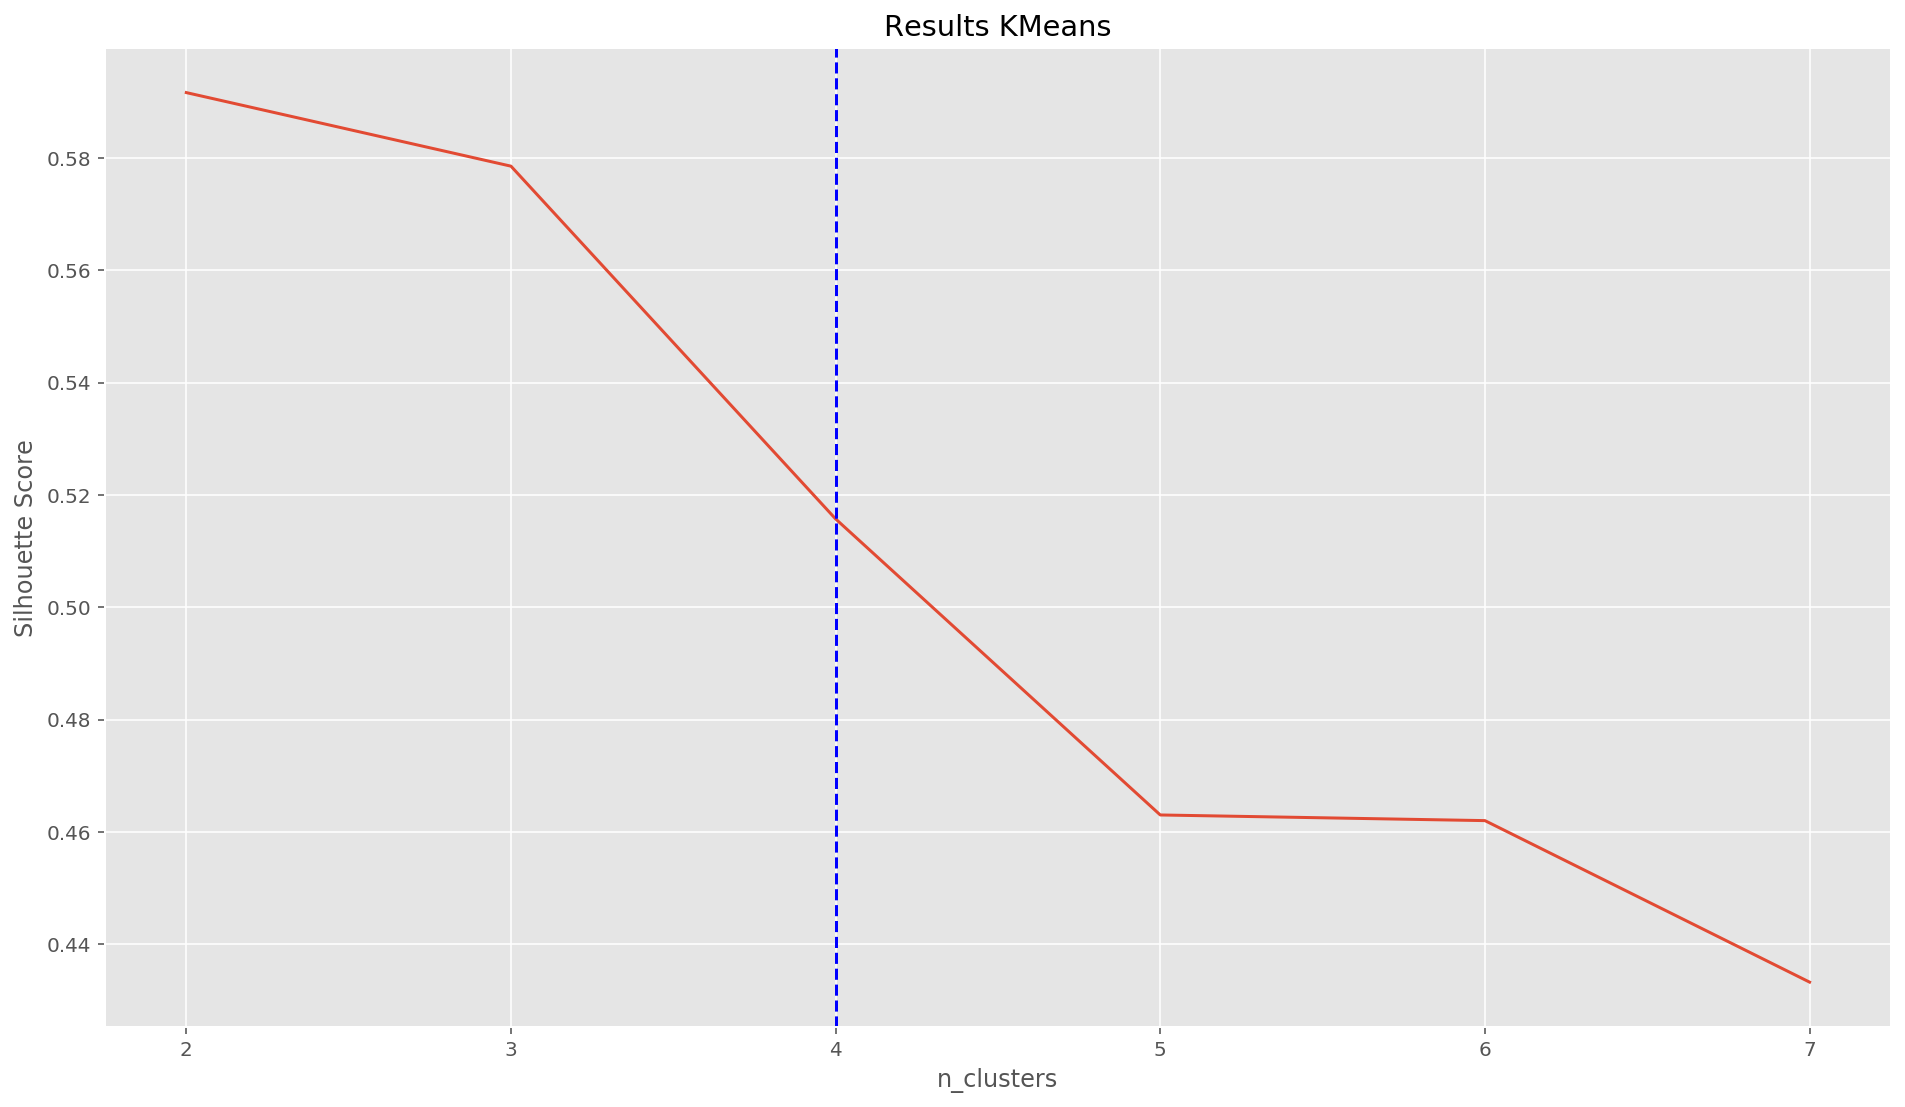

In [29]:
# シルエット分析によってkの値を考える
plt.plot(range(2,8), scores);
plt.title('Results KMeans')
plt.xlabel('n_clusters');
plt.axvline(x=4, color='blue', linestyle='--')
plt.ylabel('Silhouette Score');
plt.show()

# k=4 に決定

In [30]:
# Kmeans clustering
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=4,random_state=30).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)

print(centers)

# 3次元座標軸に4つの重心が算出されていることを確認

[[ 1.75610962e+00  2.19196795e+00  3.82712577e-02]
 [ 1.59453706e+00 -9.84519698e-01 -2.56653124e-01]
 [-9.87636103e-01 -1.34155281e-03  3.60656479e-02]
 [ 6.35939638e+00 -8.90472323e-01  4.08379114e-01]]


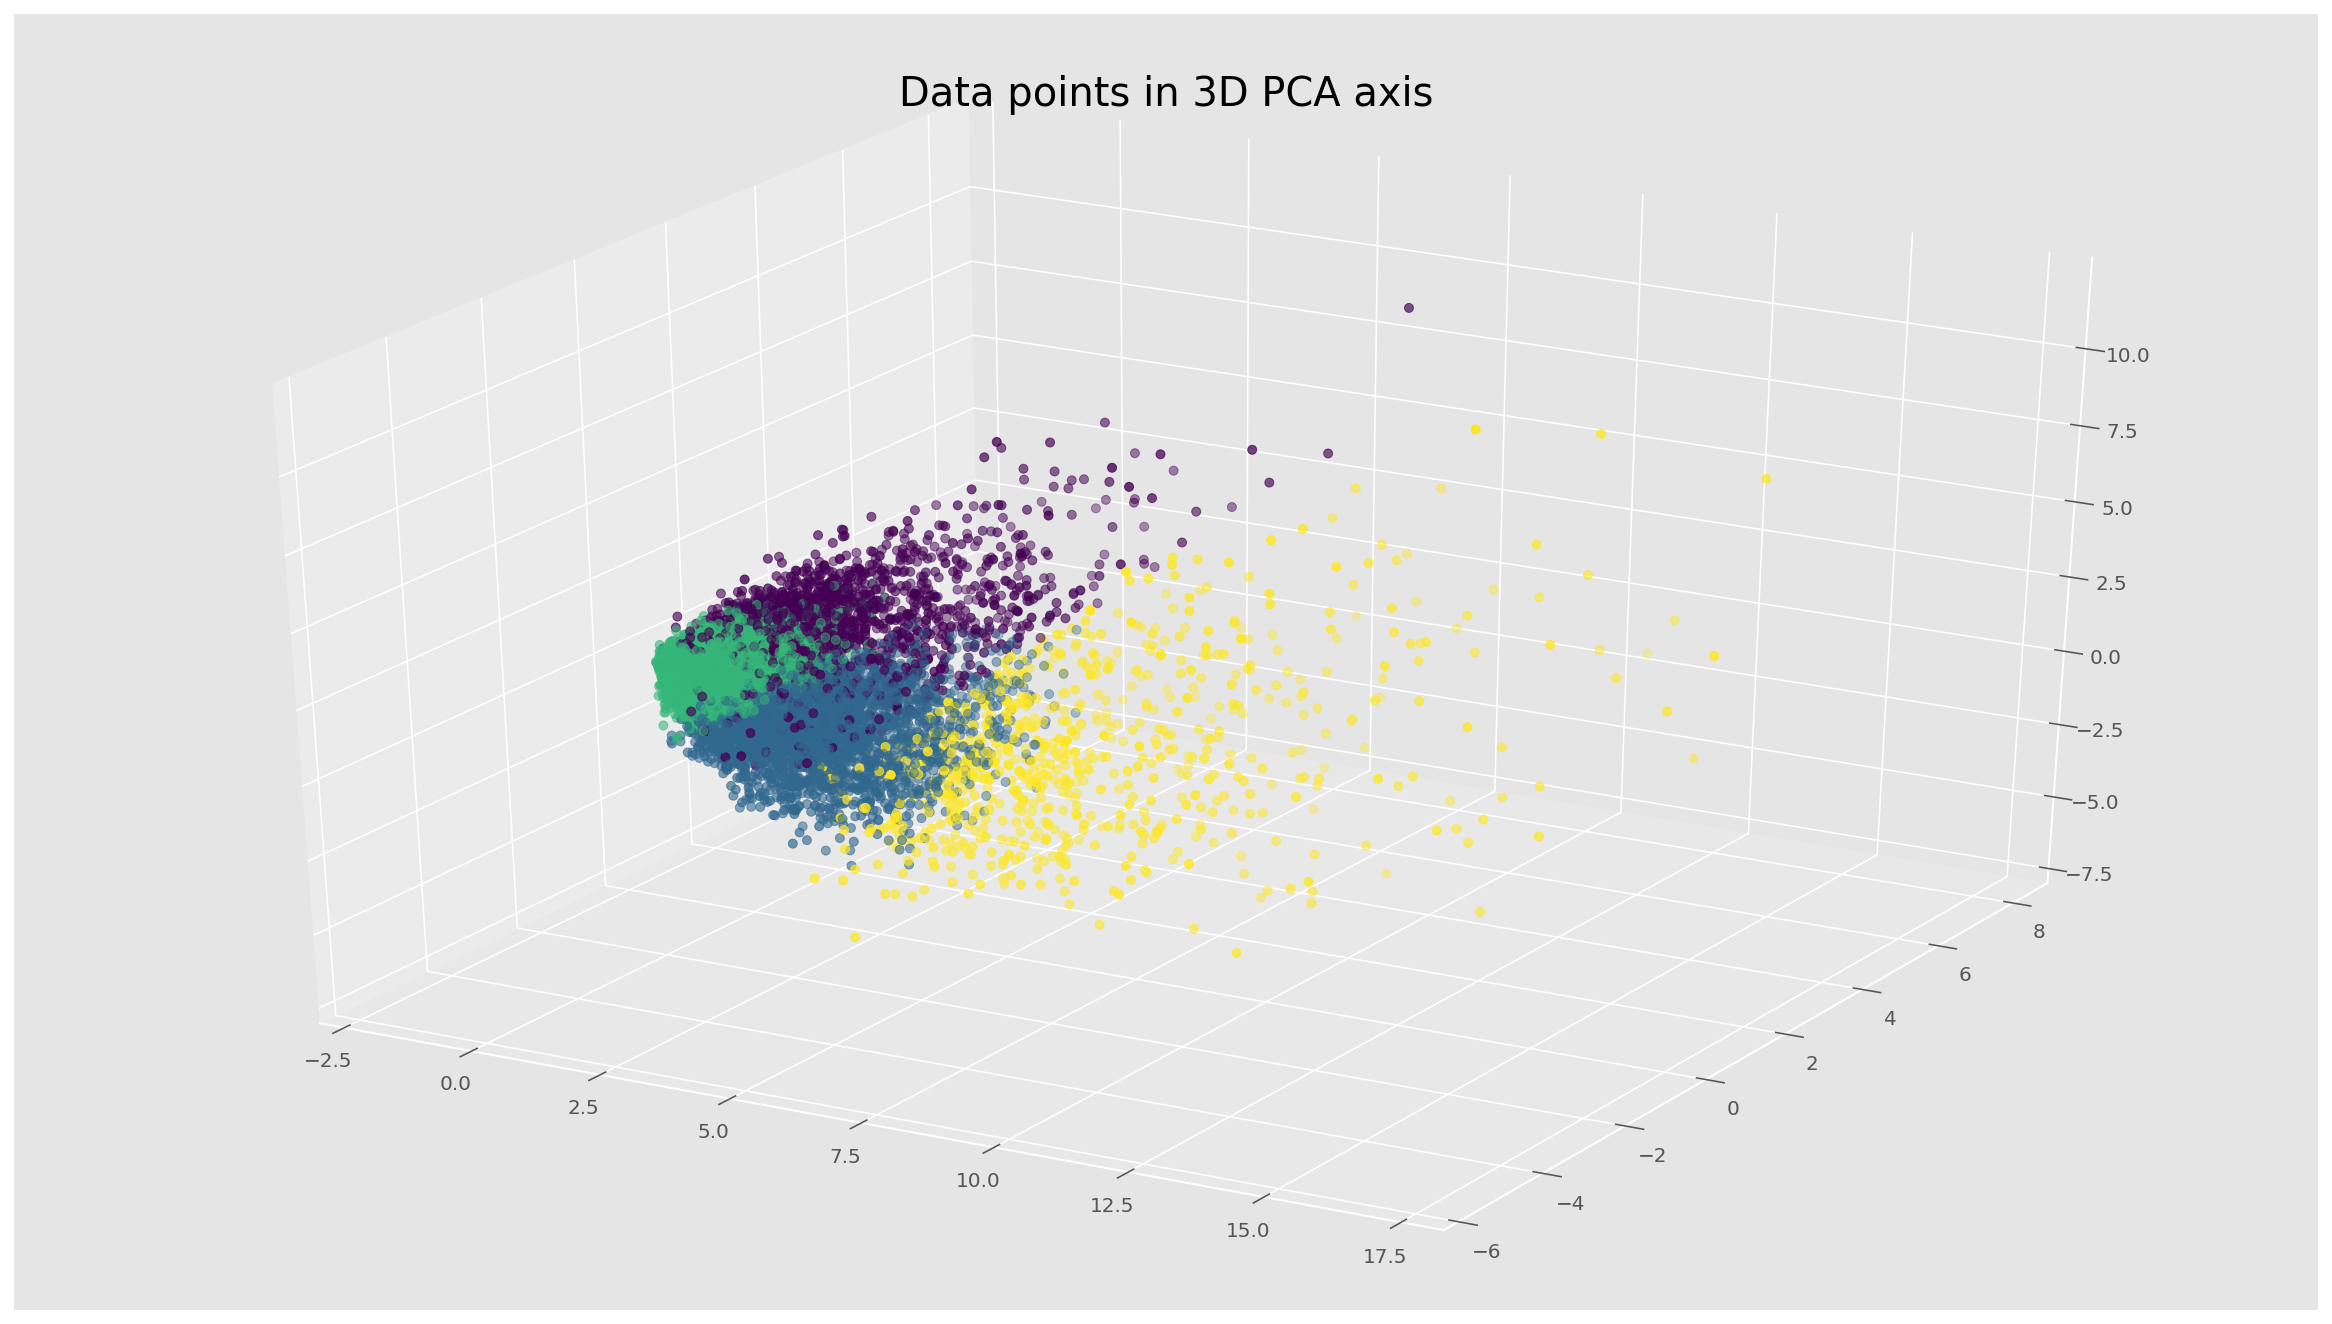

In [31]:
# データセットに対するクラスタリング結果を3Dグラフで描画
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(tocluster[0], tocluster[2], tocluster[1], c = c_preds)
plt.title('Data points in 3D PCA axis', fontsize=20)

plt.show()

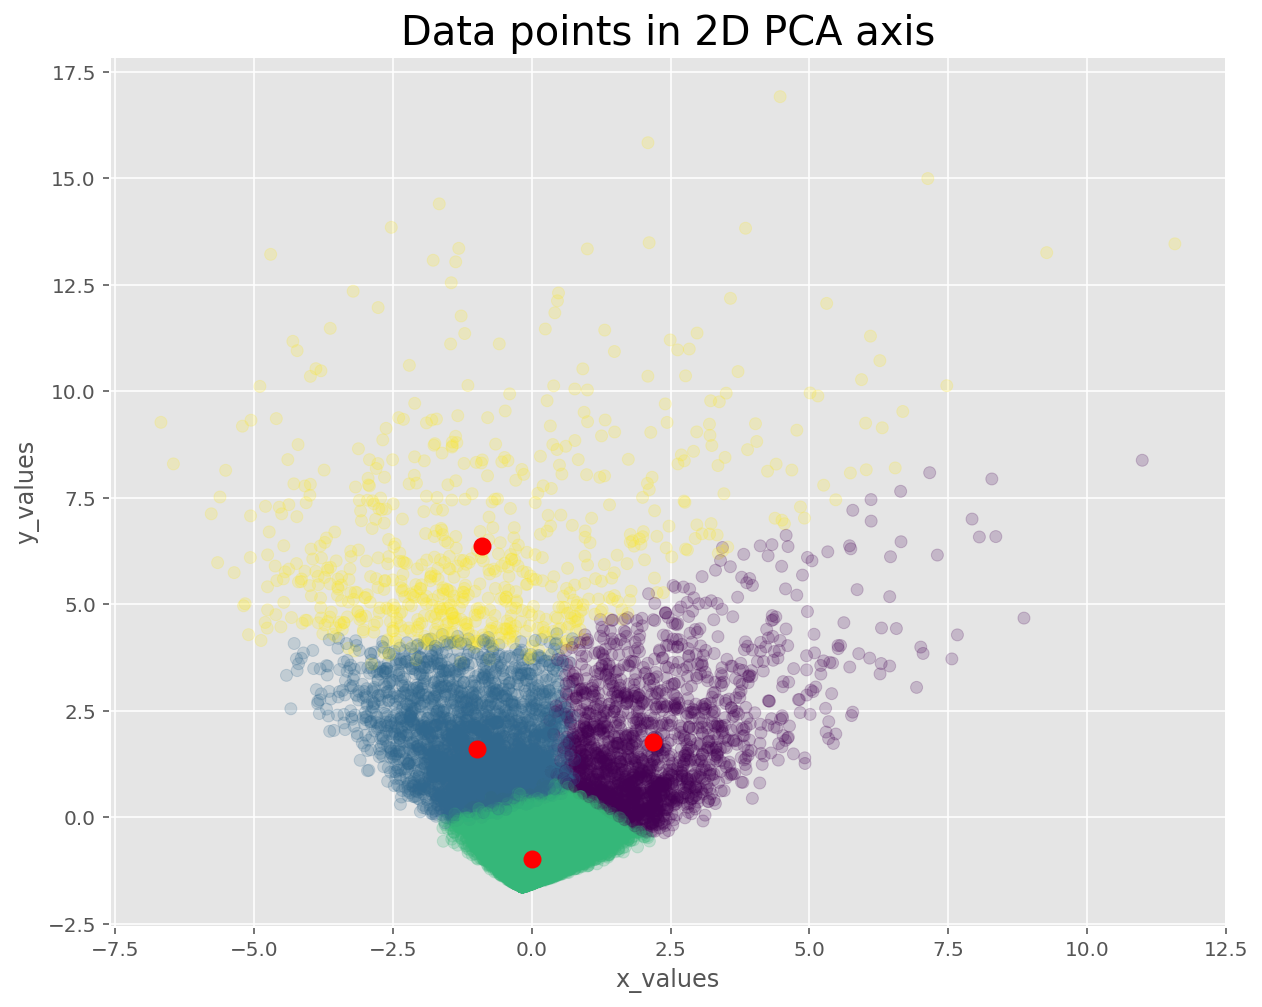

In [65]:
# 2Dグラフで描画
# 重心は赤い点でプロットする

fig = plt.figure(figsize=(10,8))
plt.scatter(tocluster[1],tocluster[0],c = c_preds, alpha=0.2)
for ci,c in enumerate(centers):
    plt.plot(c[1], c[0], 'o', markersize=8, color='red', alpha=1)

plt.xlabel('x_values')
plt.ylabel('y_values')

plt.title('Data points in 2D PCA axis', fontsize=20)
plt.show()

# 4.各クラスターの特徴の考察

In [33]:
# user_animeデータセットの最後に、クラスターを示すカラムを追加
user_anime['cluster'] = c_preds

# それぞれのクラスターの特徴を調べるため、クラスターごとにデータセットを作る
c0 = user_anime[user_anime['cluster']==0].drop('cluster',axis=1).mean()
c1 = user_anime[user_anime['cluster']==1].drop('cluster',axis=1).mean()
c2 = user_anime[user_anime['cluster']==2].drop('cluster',axis=1).mean()
c3 = user_anime[user_anime['cluster']==3].drop('cluster',axis=1).mean()

In [34]:
# ためしに、クラスター0のアニメを評価順で観察してみる
c0.sort_values(ascending=False)[0:15]

#なんとなく、SF、シリアス系、メカ、ダーク系のアニメが多い印象。

name
Code Geass: Hangyaku no Lelouch       0.649044
Death Note                            0.638358
Sen to Chihiro no Kamikakushi         0.597300
Code Geass: Hangyaku no Lelouch R2    0.591676
Tengen Toppa Gurren Lagann            0.548931
Fullmetal Alchemist                   0.548369
Cowboy Bebop                          0.547244
Neon Genesis Evangelion               0.538808
Suzumiya Haruhi no Yuuutsu            0.523060
Fullmetal Alchemist: Brotherhood      0.518560
Mononoke Hime                         0.516873
Howl no Ugoku Shiro                   0.482002
Toki wo Kakeru Shoujo                 0.470754
Samurai Champloo                      0.469066
Toradora!                             0.463442
dtype: float64

In [35]:
# クラスター1のアニメを評価順で観察してみる
c1.sort_values(ascending=False)[0:15]

#クラスター0にもみられたアニメもあるが、、ファンタジー、アクション、恋愛の要素が多い印象。

name
Shingeki no Kyojin                                          0.669018
No Game No Life                                             0.572086
Death Note                                                  0.553681
Sword Art Online                                            0.550000
Angel Beats!                                                0.542638
Steins;Gate                                                 0.540798
Fullmetal Alchemist: Brotherhood                            0.533436
Code Geass: Hangyaku no Lelouch                             0.493558
Code Geass: Hangyaku no Lelouch R2                          0.468712
Toradora!                                                   0.462883
Mirai Nikki (TV)                                            0.450307
One Punch Man                                               0.427301
Tokyo Ghoul                                                 0.388957
Noragami                                                    0.384356
Ano Hi Mita Hana no Namae wo 

In [36]:
# クラスター2のアニメを評価順で観察してみる
c2.sort_values(ascending=False)[0:15]

#全体的に値が低い、かつアニメタイトルに共通項が見受けられないことから、上記クラスターの3Dグラフの黄色に属するクラスターと考えられる

name
Death Note                            0.293813
Shingeki no Kyojin                    0.205273
Fullmetal Alchemist: Brotherhood      0.169994
Sword Art Online                      0.165422
Code Geass: Hangyaku no Lelouch       0.164965
Sen to Chihiro no Kamikakushi         0.153307
Code Geass: Hangyaku no Lelouch R2    0.143859
Fullmetal Alchemist                   0.141344
Angel Beats!                          0.132429
Elfen Lied                            0.125724
Ouran Koukou Host Club                0.118561
Naruto                                0.118180
Howl no Ugoku Shiro                   0.109189
Toradora!                             0.103170
Steins;Gate                           0.100884
dtype: float64

In [37]:
# クラスター3のアニメを評価順で観察してみる
c3.sort_values(ascending=False)[0:15]

#他のクラスターと比較して、特に恋愛、感動の要素が多い印象。

name
Angel Beats!                          0.825549
No Game No Life                       0.810440
Steins;Gate                           0.803571
Toradora!                             0.792582
Shingeki no Kyojin                    0.777473
Code Geass: Hangyaku no Lelouch       0.765110
Code Geass: Hangyaku no Lelouch R2    0.751374
Fullmetal Alchemist: Brotherhood      0.740385
Death Note                            0.729396
Bakemonogatari                        0.697802
Sword Art Online                      0.686813
One Punch Man                         0.677198
Clannad: After Story                  0.675824
Hataraku Maou-sama!                   0.670330
Mirai Nikki (TV)                      0.668956
dtype: float64

In [38]:
def createAnimeInfoList(animelist):
    #各アニメタイトルの情報（episodes,members,rating,genre）をまとめたリストを作る関数
    episode_list = list()
    genre_list = list()
    member_list = list()
    rating_list= list()
    for x in anime['name']:
        if x in animelist:
            episode_list.append(anime[anime['name']==x].episodes.values.astype(int))
            member_list.append(anime[anime['name']==x].members.values.astype(int))
            rating_list.append(anime[anime['name']==x].rating.values.astype(int))
            for y in anime[anime['name']==x].genre.values:
                 genre_list.append(y)
    return genre_list,episode_list,rating_list,member_list

In [39]:
def count_word(df, ref_col, liste):
    #各ワードの数をカウントする関数
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split(','):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [40]:
animelist = list(c0.index)
data = pd.DataFrame()
data['genre'],data['episode'],data['rating'],data['member'] =  createAnimeInfoList(animelist)


In [41]:
set_keywords = set()
for liste_keywords in data['genre'].str.split(',').values:
    if isinstance(liste_keywords, float): continue  # キーワードがNANのときのみ生じる
    set_keywords = set_keywords.union(liste_keywords)

In [43]:
from wordcloud import WordCloud

def makeCloud(Dict,name,color):
    #ワードクラウドの画像を描画するための関数
    words = dict()

    for s in Dict:
        words[s[0]] = s[1]

        wordcloud = WordCloud(
                      width=1500,
                      height=500, 
                      background_color=color, 
                      max_words=20,
                      max_font_size=500, 
                      normalize_plurals=False)
        wordcloud.generate_from_frequencies(words)


    fig = plt.figure(figsize=(12, 8))
    plt.title(name)
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()

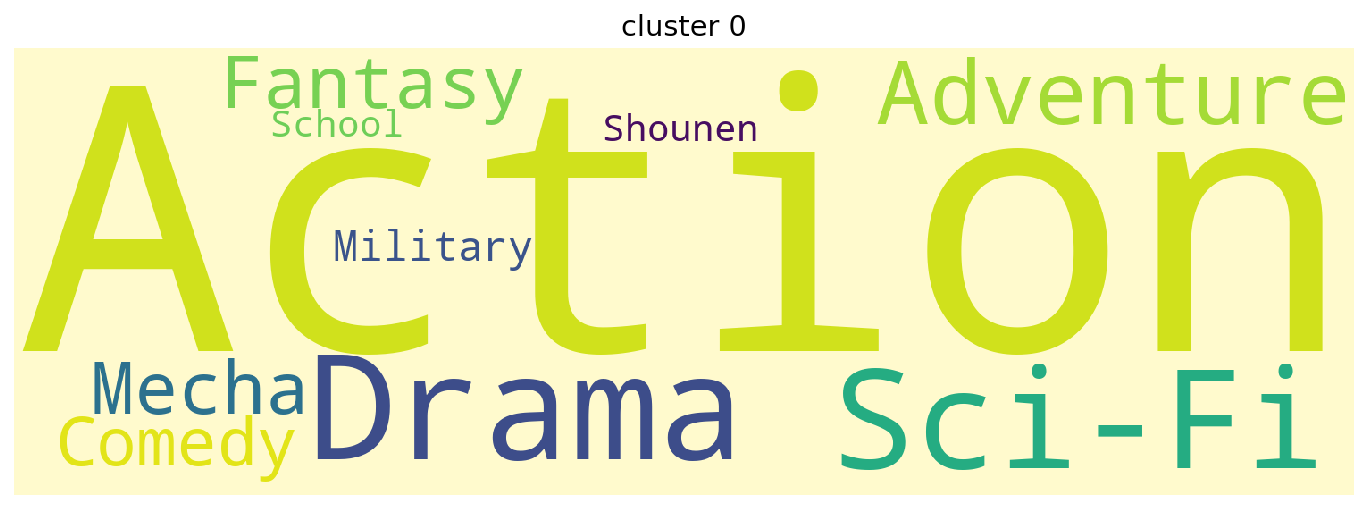

In [44]:
c0_animelist = list(c0.sort_values(ascending=False)[0:15].index)
c0_data = pd.DataFrame()
c0_data['genre'],c0_data['episode'],c0_data['rating'],c0_data['member'] =  createAnimeInfoList(c0_animelist)
c0_data.iloc[:,1:4] = c0_data.iloc[:,1:4].astype(int) # change to numeric object to integer
keyword_occurences, dum = count_word(c0_data, 'genre', set_keywords)
makeCloud(keyword_occurences[0:10],"cluster 0","lemonchiffon")

In [311]:
print('cluster 0\nAVG episode : {0}\nAVG movie rating : {1}\nAVG member : {2}'
      .format(c0_data['episode'].mean(), c0_data['rating'].mean(),c0_data['member'].mean()))

print(keyword_occurences[0:5])

# 定量的にも確認

cluster 0
AVG episode : 21.7
AVG movie rating : 8.066666666666666
AVG member : 485147.1
[['Action', 16], [' Supernatural', 15], [' Romance', 11], [' Fantasy', 9], [' Drama', 9]]


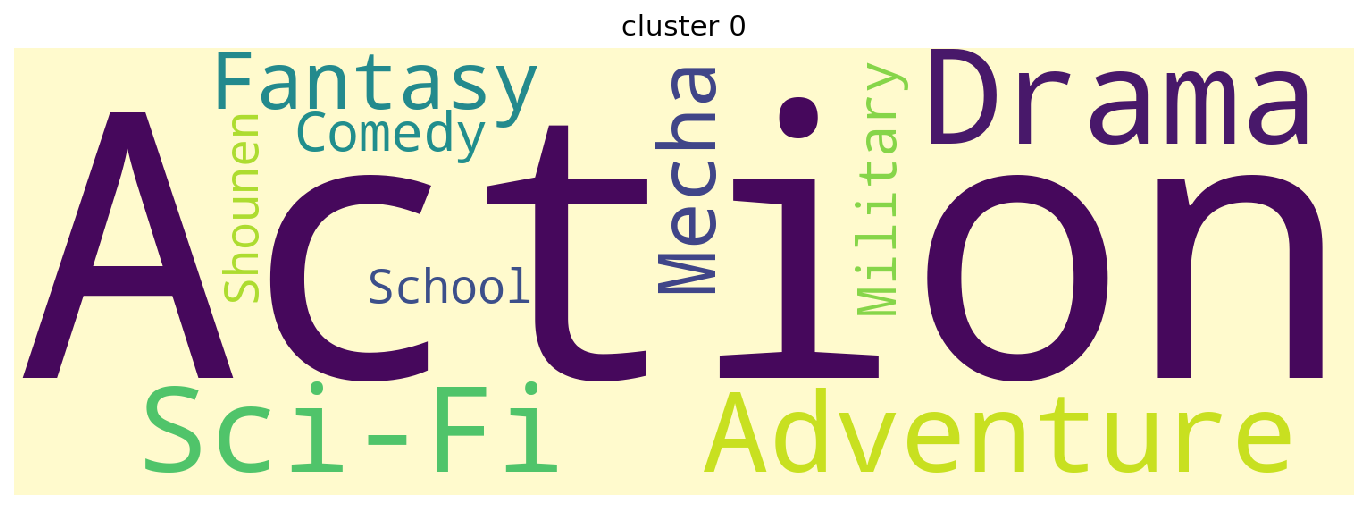

cluster 0
AVG episode : 23.333333333333332
AVG movie rating : 8.066666666666666
AVG member : 539226.7333333333
[['Action', 9], [' Drama', 8], [' Sci-Fi', 7], [' Adventure', 6], [' Fantasy', 4]]


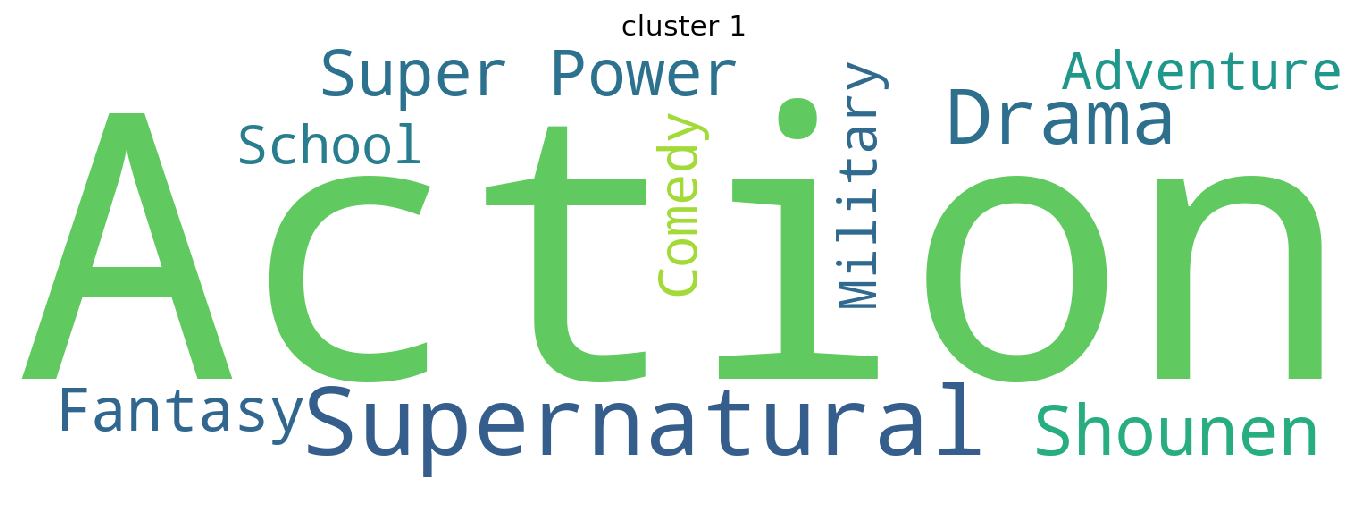

cluster 1
AVG episode : 23.2
AVG movie rating : 8.066666666666666
AVG member : 687956.2
[['Action', 10], [' Supernatural', 8], [' Drama', 5], [' Shounen', 4], [' Super Power', 4]]


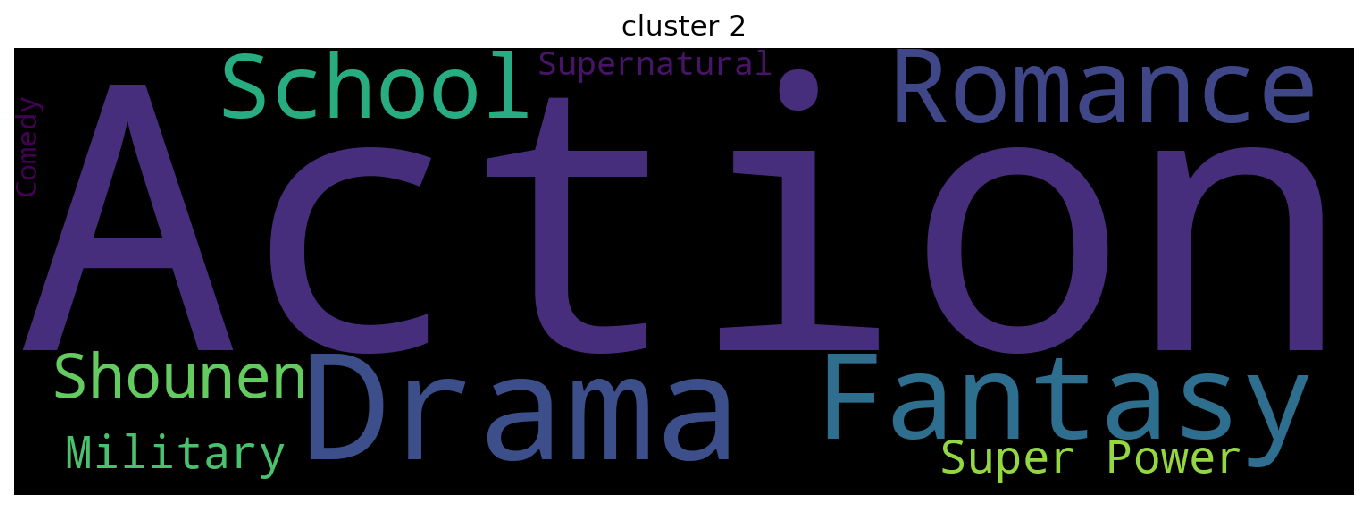

cluster 2
AVG episode : 38.333333333333336
AVG movie rating : 7.933333333333334
AVG member : 669269.2
[['Action', 9], [' Drama', 8], [' Fantasy', 5], [' Romance', 5], [' School', 4]]


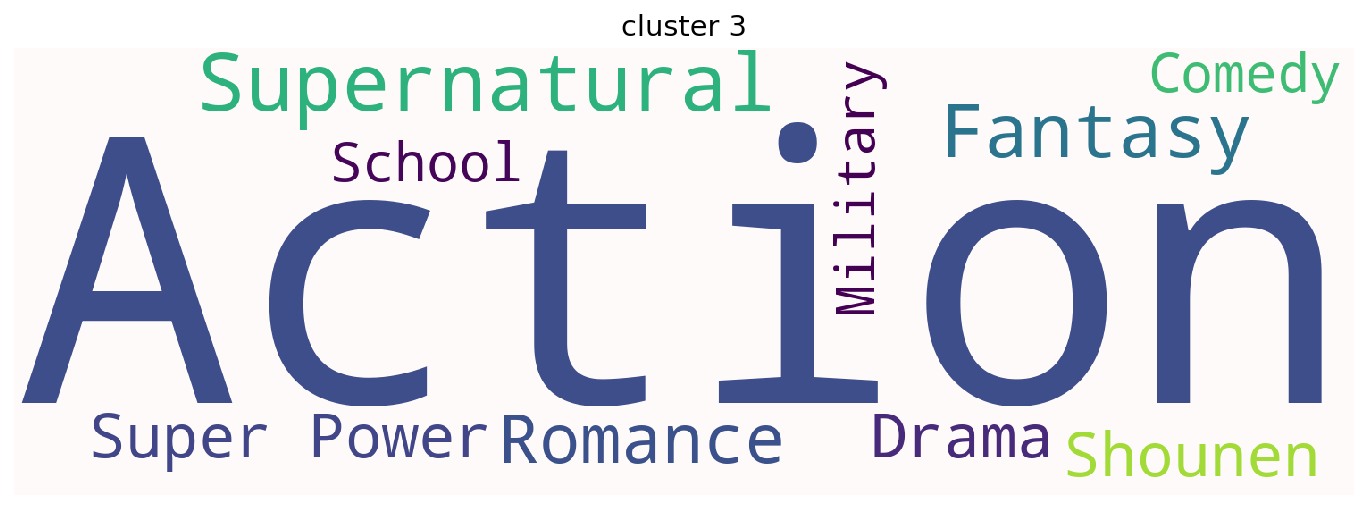

cluster 3
AVG episode : 24.333333333333332
AVG movie rating : 8.133333333333333
AVG member : 671341.8666666667
[['Action', 8], [' Supernatural', 7], [' Fantasy', 6], [' Romance', 5], [' Shounen', 4]]


In [313]:
# 4つのクラスターを全て表示してみる
c0_animelist = list(c0.sort_values(ascending=False)[0:15].index)
c0_data = pd.DataFrame()
c0_data['genre'],c0_data['episode'],c0_data['rating'],c0_data['member'] =  createAnimeInfoList(c0_animelist)
c0_data.iloc[:,1:4] = c0_data.iloc[:,1:4].astype(int) # change to numeric object to integer
keyword_occurences, dum = count_word(c0_data, 'genre', set_keywords)
makeCloud(keyword_occurences[0:10],"cluster 0","lemonchiffon")

print('cluster 0\nAVG episode : {0}\nAVG movie rating : {1}\nAVG member : {2}'
      .format(c0_data['episode'].mean(), c0_data['rating'].mean(),c0_data['member'].mean()))
print(keyword_occurences[0:5])

c1_animelist = list(c1.sort_values(ascending=False)[0:15].index)
c1_data = pd.DataFrame()
c1_data['genre'],c1_data['episode'],c1_data['rating'],c1_data['member'] =  createAnimeInfoList(c1_animelist)
c1_data.iloc[:,1:4] = c1_data.iloc[:,1:4].astype(int)
keyword_occurences, dum = count_word(c1_data, 'genre', set_keywords)
makeCloud(keyword_occurences[0:10],"cluster 1","white")


print('cluster 1\nAVG episode : {0}\nAVG movie rating : {1}\nAVG member : {2}'
      .format(c1_data['episode'].mean(), c1_data['rating'].mean(),c1_data['member'].mean()))
print(keyword_occurences[0:5])

c2_animelist = list(c2.sort_values(ascending=False)[0:15].index)
c2_data = pd.DataFrame()
c2_data['genre'],c2_data['episode'],c2_data['rating'],c2_data['member'] =  createAnimeInfoList(c2_animelist)
c2_data.iloc[:,1:4] = c2_data.iloc[:,1:4].astype(int)
keyword_occurences, dum = count_word(c2_data, 'genre', set_keywords)
makeCloud(keyword_occurences[0:10],"cluster 2","black")


print('cluster 2\nAVG episode : {0}\nAVG movie rating : {1}\nAVG member : {2}'
      .format(c2_data['episode'].mean(), c2_data['rating'].mean(),c2_data['member'].mean()))
print(keyword_occurences[0:5])

c3_animelist = list(c3.sort_values(ascending=False)[0:15].index)
c3_data = pd.DataFrame()
c3_data['genre'],c3_data['episode'],c3_data['rating'],c3_data['member'] =  createAnimeInfoList(c3_animelist)
c3_data.iloc[:,1:4] = c3_data.iloc[:,1:4].astype(int)
keyword_occurences, dum = count_word(c3_data, 'genre', set_keywords)
makeCloud(keyword_occurences[0:10],"cluster 3","snow")


print('cluster 3\nAVG episode : {0}\nAVG movie rating : {1}\nAVG member : {2}'
      .format(c3_data['episode'].mean(), c3_data['rating'].mean(),c3_data['member'].mean()))
print(keyword_occurences[0:5])

In [315]:
# 人気順15個のアニメタイトルだと、どのクラスターもActionの要素が最も高い。
# そのため、人気順上位30タイトルの中で、Action以外の要素でワードクラウドを描画してみる

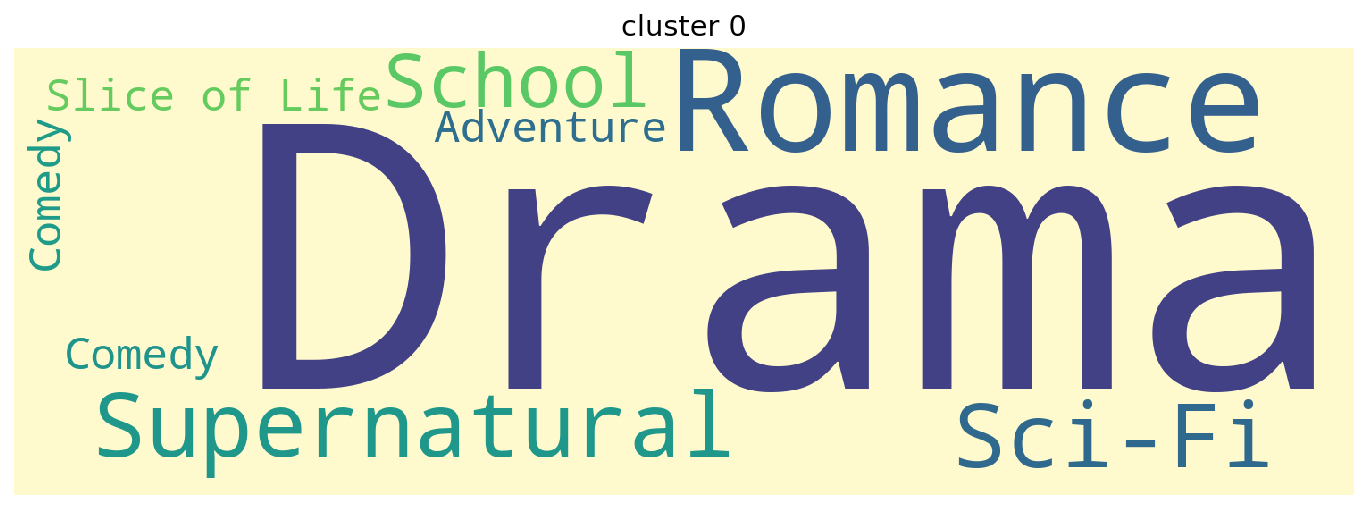

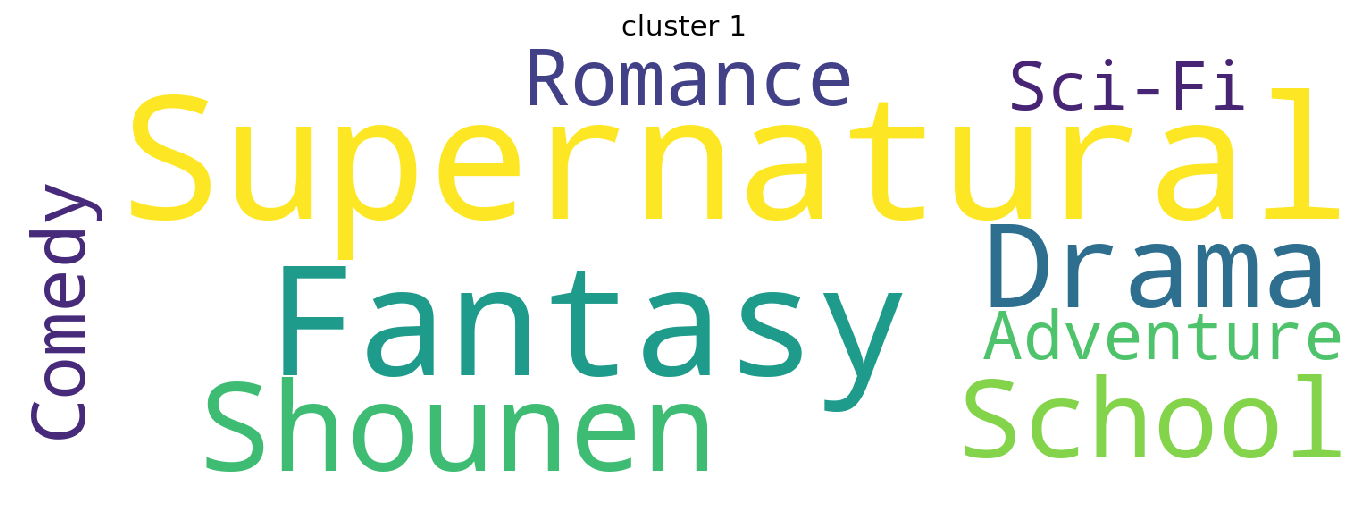

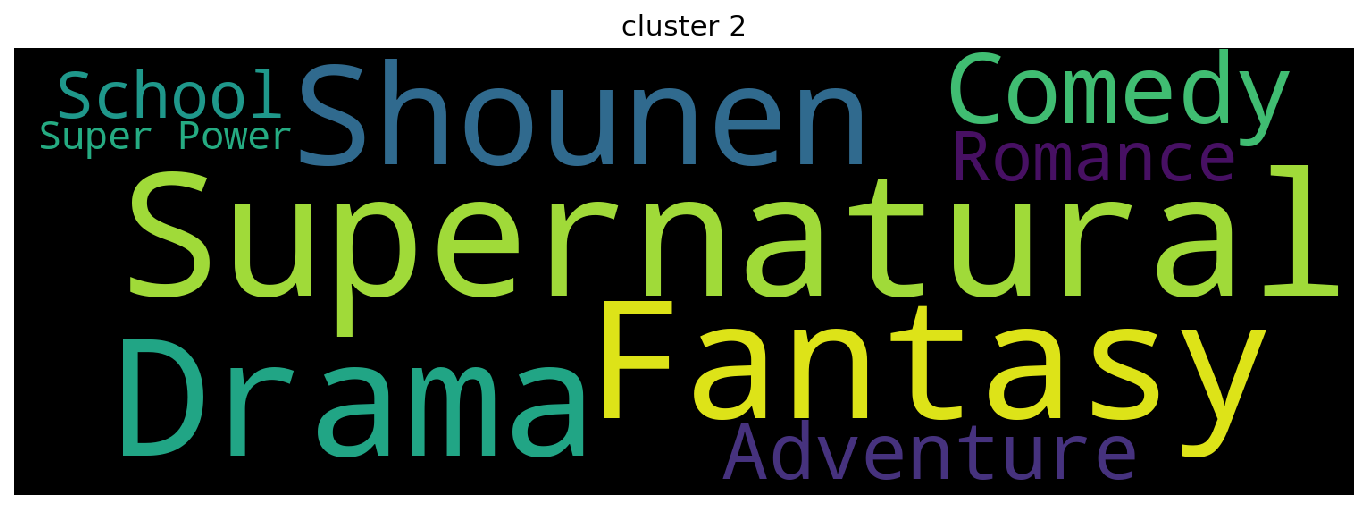

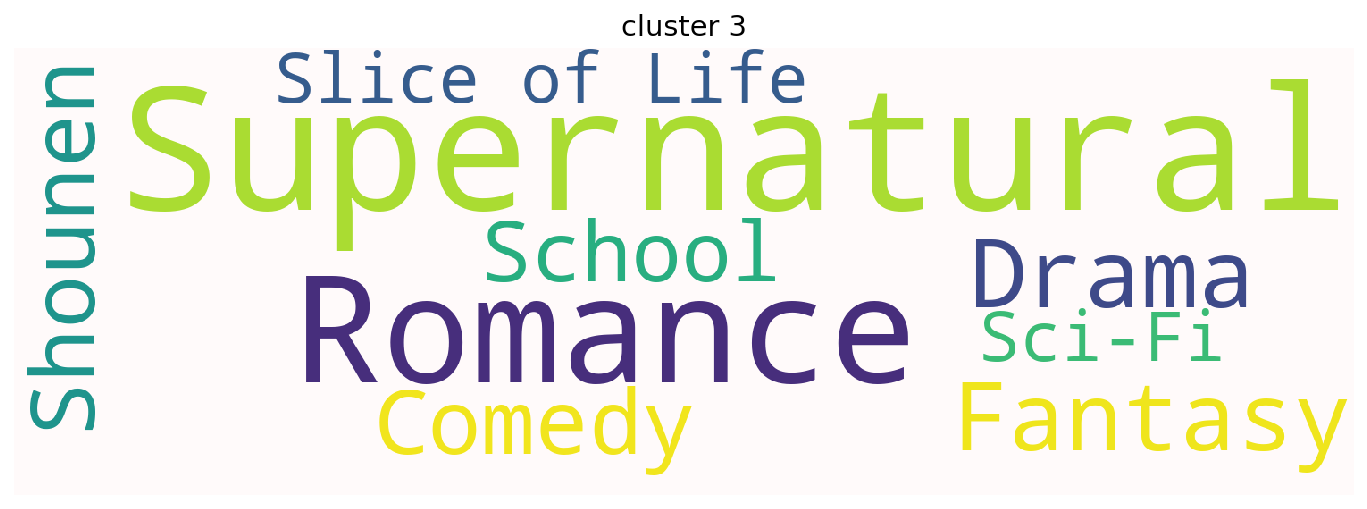

In [314]:
c0_animelist = list(c0.sort_values(ascending=False)[0:30].index)
c0_data = pd.DataFrame()
c0_data['genre'],c0_data['episode'],c0_data['rating'],c0_data['member'] =  createAnimeInfoList(c0_animelist)
c0_data.iloc[:,1:4] = c0_data.iloc[:,1:4].astype(int) # change to numeric object to integer
keyword_occurences, dum = count_word(c0_data, 'genre', set_keywords)
makeCloud(keyword_occurences[1:10],"cluster 0","lemonchiffon")

c1_animelist = list(c1.sort_values(ascending=False)[0:30].index)
c1_data = pd.DataFrame()
c1_data['genre'],c1_data['episode'],c1_data['rating'],c1_data['member'] =  createAnimeInfoList(c1_animelist)
c1_data.iloc[:,1:4] = c1_data.iloc[:,1:4].astype(int)
keyword_occurences, dum = count_word(c1_data, 'genre', set_keywords)
makeCloud(keyword_occurences[1:10],"cluster 1","white")

c2_animelist = list(c2.sort_values(ascending=False)[0:30].index)
c2_data = pd.DataFrame()
c2_data['genre'],c2_data['episode'],c2_data['rating'],c2_data['member'] =  createAnimeInfoList(c2_animelist)
c2_data.iloc[:,1:4] = c2_data.iloc[:,1:4].astype(int)
keyword_occurences, dum = count_word(c2_data, 'genre', set_keywords)
makeCloud(keyword_occurences[1:10],"cluster 2","black")

c3_animelist = list(c3.sort_values(ascending=False)[0:30].index)
c3_data = pd.DataFrame()
c3_data['genre'],c3_data['episode'],c3_data['rating'],c3_data['member'] =  createAnimeInfoList(c3_animelist)
c3_data.iloc[:,1:4] = c3_data.iloc[:,1:4].astype(int)
keyword_occurences, dum = count_word(c3_data, 'genre', set_keywords)
makeCloud(keyword_occurences[1:10],"cluster 3","snow")

## 上記結果から読み取れること
### クラスター0について
- 「ドラマ」「ロマンス」の要素が大部分を占めていることから、心理描写の多い恋愛モノが多いと推測できる
- 他の要素として「Comedy」が二つあることから、ラブコメディと呼ばれるジャンルと推測できる
- 他の要素であるアドベンチャー、スクール、SFの要素は、ラブコメディにおいて人気な世界観であると推測できる
- 他クラスターが[supernatural]の要素が強いのに対し、クラスター0は比較的弱めなことから、現実的な世界観のアニメが多いことが推測できる


### クラスター1について
- クラスター２と類似している点として、[supernatural],[fantasy],[shounen],[drama],[adventure]の要素の強さがほぼ等しい点。非日常的で冒険、アクション要素の強い作品群であると推測できる。
- クラスター２と異なっているのは、[school],[romance]の要素が強いこと、また[SF]の要素がある点。世界観として学園や恋愛の作品が多いと推測できる。

### クラスター2について
- クラスター１と異なっているのは[Comedy]の要素が強いこと。クラスター１と比較してポップなタッチで笑いの要素が強い作品群と推測できる。

### クラスター3について
- クラスター1,2と類似している点は[Supernatural]の要素が一番強い点。どれも非現実的な世界観の作品と推測できる。
- クラスター1,2と異なる点は、[Shounen]の要素が弱く、[Romance],[Drama]の要素が強い点と、[Slice of Life]の要素がある点。クラスター１，２が激しく活発な印象なのに対し、クラスター３は心理描写が多めで、ストーリーが複雑な作品が多いと推測できる。

### すべてのクラスターについて
- すべてのクラスターにおいて[Action]の要素が最も強かったことから、ほとんどの人気作品にはアクションの要素が含まれていることが推測できる。
- また、非現実的（supernatural）要素が弱い作品の場合、[Drama],[Romance]の要素が強くなければ人気作品にはなりにくいと推測できる。
- また、世界観として人気なのはschool,adventure,fantasyであり、ついでcomedy,SFがあると推測できる。

Text(0, 0.5, 'member')

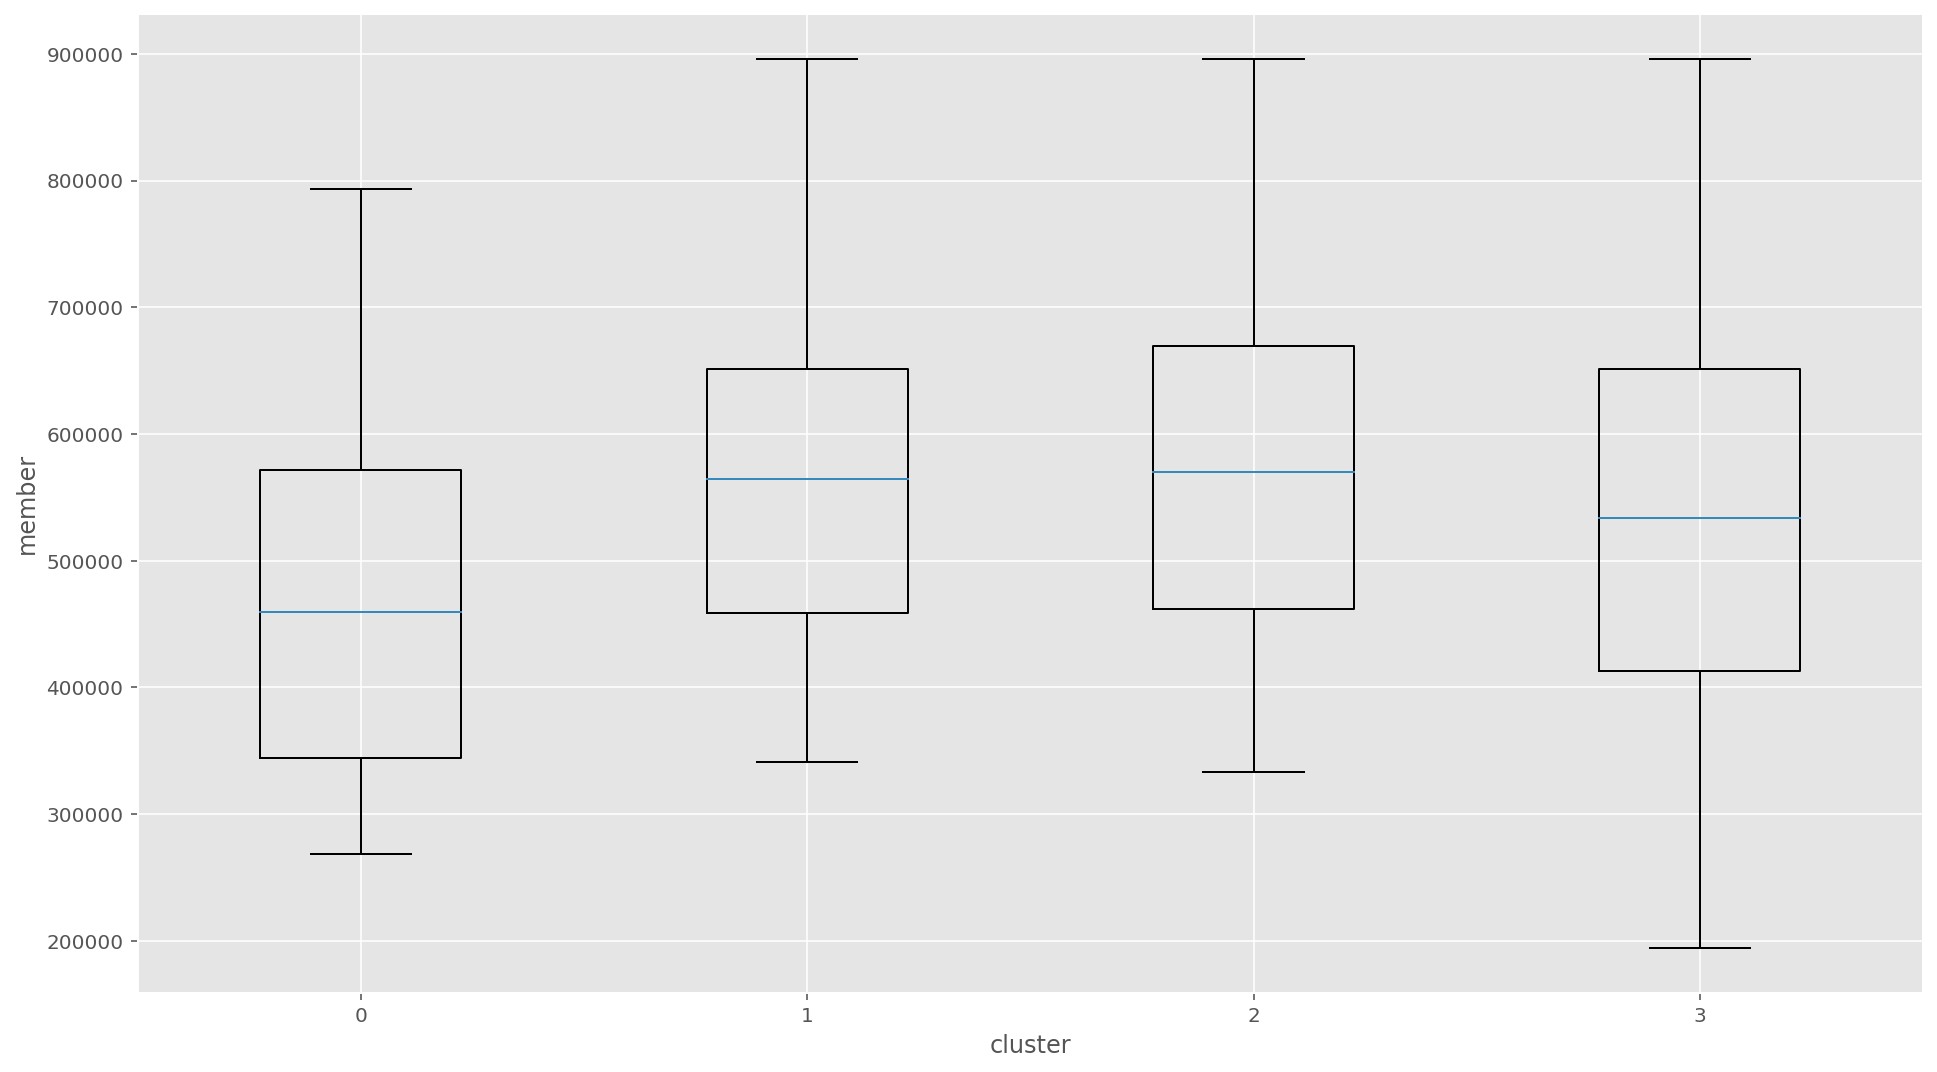

In [316]:
# クラスター別のmemberの分布を確認
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.boxplot([c0_data['member'],c1_data['member'],c2_data['member'],c3_data['member']], labels=['0','1','2','3'], sym="")
ax.set_xlabel('cluster')
ax.set_ylabel('member')

- クラスター１は他クラスターに比べてmember数の少ない作品群が多いことを確認。ややマニア向けの作品群であると予想される。

Text(0, 0.5, 'episode')

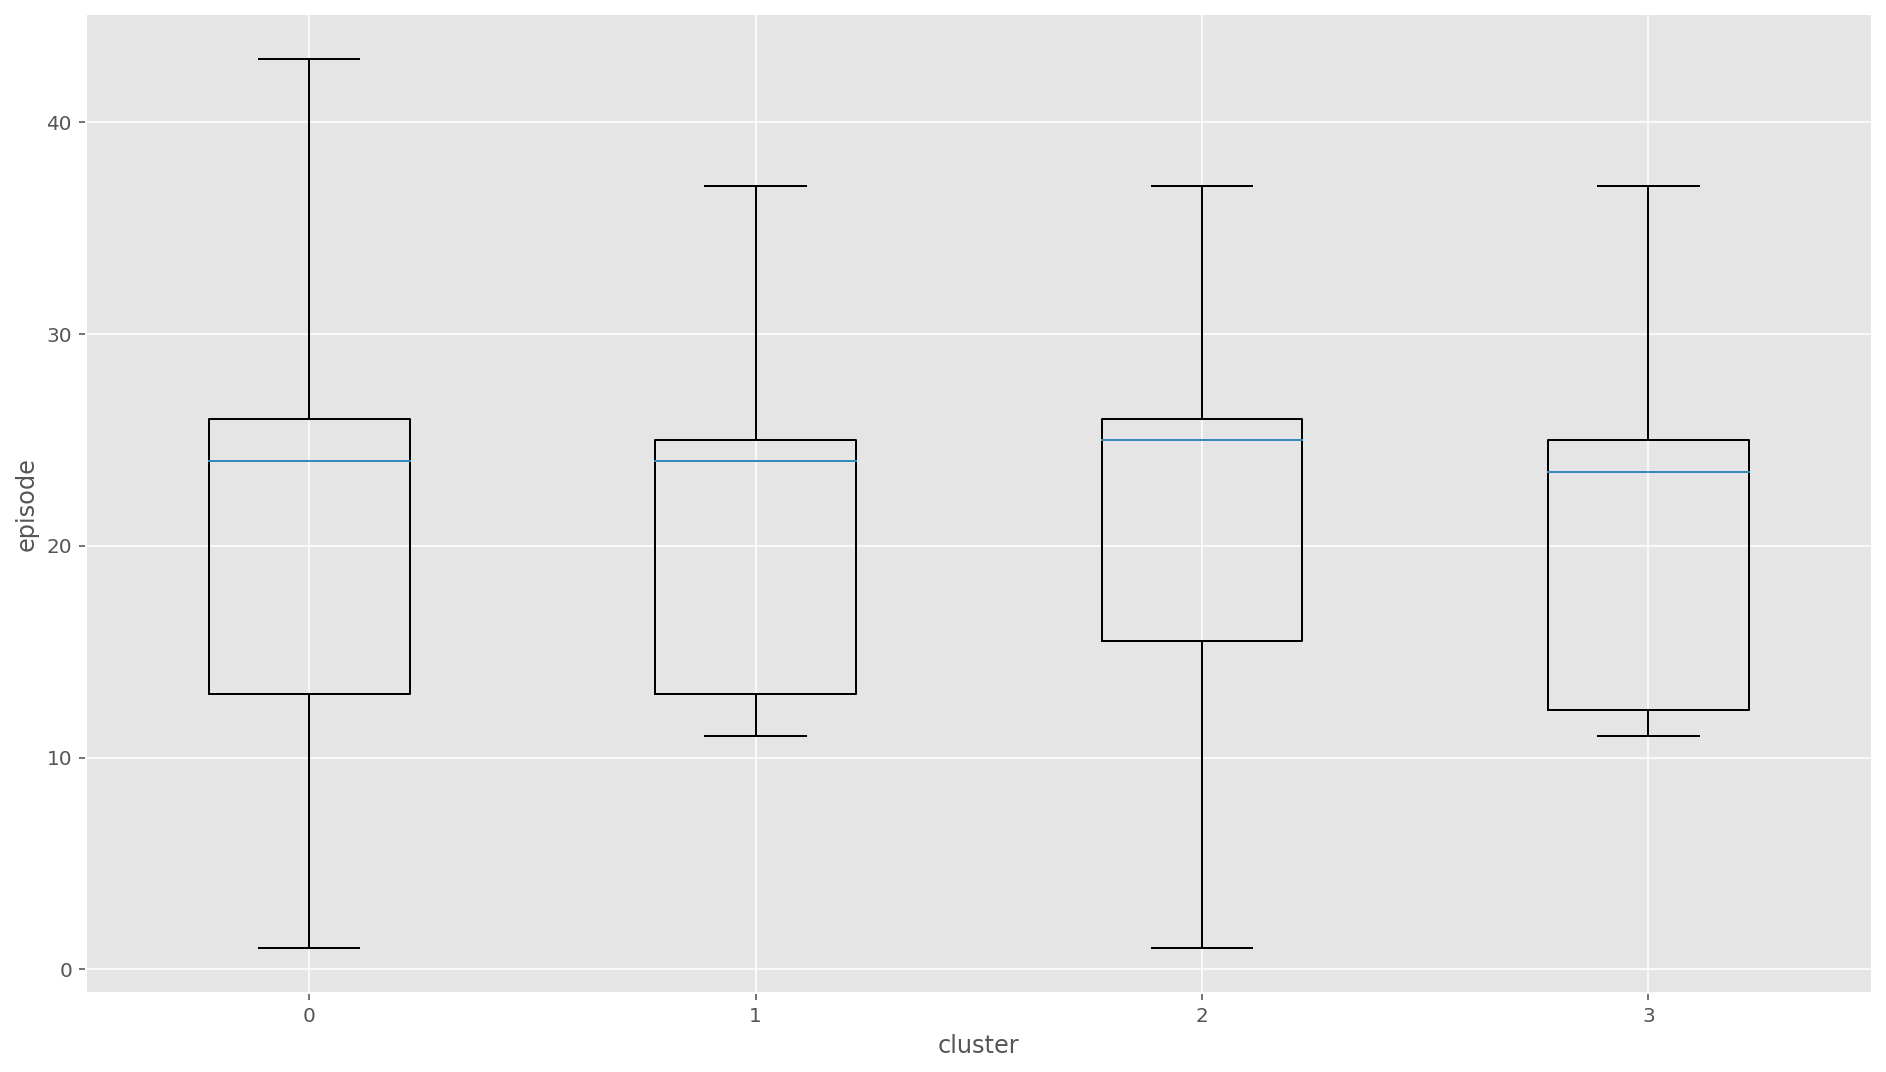

In [319]:
# クラスター別のepisodeの分布を確認
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.boxplot([c0_data['episode'],c1_data['episode'],c2_data['episode'],c3_data['episode']], labels=['0','1','2','3'], sym="")
ax.set_xlabel('cluster')
ax.set_ylabel('episode')

- 最小値を比較すると、クラスター0,2は1，2話だけの作品も含まれていることから、映画作品も含まれたカテゴリであると推測できる
- 最大値を比較すると、クラスター0は他クラスターと比較して長編作品が多く含まれた作品群だと推測できる
- 四分位範囲を比較すると、どのクラスターも12~27話の範囲になっていることから、全てのクラスターは1、2クールのテレビアニメ作品が大部分を占めている作品群だと推測できる

(7.5, 8.5)

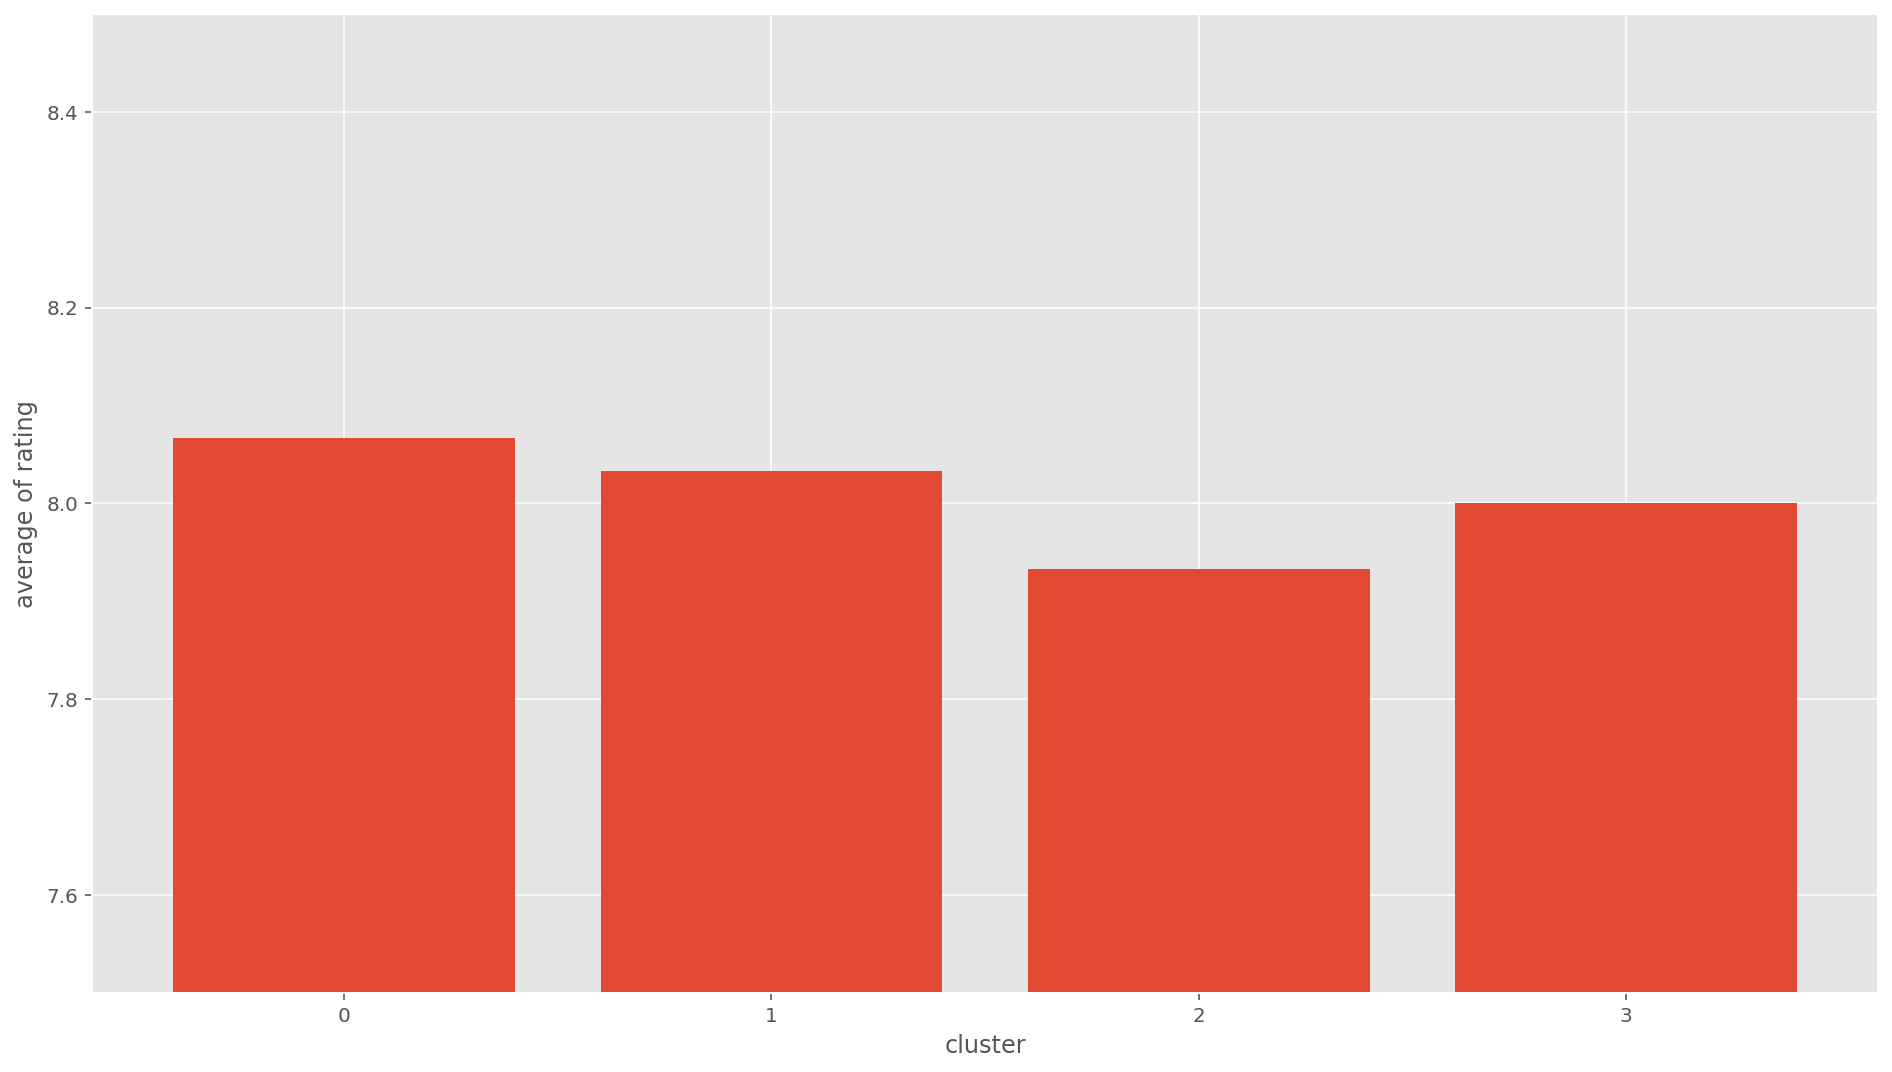

In [318]:
# クラスター別のratingの平均を確認
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#ax.bar([c0_data['rating'].mean(),c1_data['rating'].mean(),c2_data['rating'].mean(),c3_data['rating'].mean()], labels=['0','1','2','3'])
ax.bar(x=['0','1','2','3'], height = [c0_data['rating'].mean(),c1_data['rating'].mean(),c2_data['rating'].mean(),c3_data['rating'].mean()])
ax.set_xlabel('cluster')
ax.set_ylabel('average of rating')
ax.set_ylim(7.5,8.5)

- どのクラスターも評価値の平均は7.9~8.1あたりで、それほど差はないことを確認

#  5.レコメンド機能の実装

In [320]:
# 初期ユーザーがどのクラスタに属するかを識別する

suggest_list = pd.DataFrame(data=tmp,columns=['c0'])

tmp0 = pd.DataFrame(data=c0.sort_values(ascending=False)[0:15],columns=['c0']).reset_index()
tmp1 = pd.DataFrame(data=c1.sort_values(ascending=False)[0:15],columns=['c1']).reset_index()
tmp2 = pd.DataFrame(data=c2.sort_values(ascending=False)[0:15],columns=['c2']).reset_index()
tmp3 = pd.DataFrame(data=c3.sort_values(ascending=False)[0:15],columns=['c3']).reset_index()

tmp0 = pd.merge( tmp0, tmp1, how = 'outer')
tmp2 = pd.merge( tmp2, tmp3, how = 'outer')
tmp0 = pd.merge( tmp0, tmp2, how = 'outer')

suggest_list = tmp0.fillna(0)
del tmp0, tmp1, tmp2, tmp3

suggest_list = suggest_list.sort_values('name').reset_index(drop=True)
suggest_list

,name,c0,c1,c2,c3
0,Angel Beats!,0.000000,0.542638,0.132429,0.825549
1,Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...,0.000000,0.383742,0.000000,0.000000
2,Bakemonogatari,0.000000,0.000000,0.000000,0.697802
3,Clannad: After Story,0.000000,0.000000,0.000000,0.675824
4,Code Geass: Hangyaku no Lelouch,0.649044,0.493558,0.164965,0.765110
5,Code Geass: Hangyaku no Lelouch R2,0.591676,0.468712,0.143859,0.751374
6,Cowboy Bebop,0.547244,0.000000,0.000000,0.000000
7,Death Note,0.638358,0.553681,0.293813,0.729396
8,Elfen Lied,0.000000,0.000000,0.125724,0.000000
9,Fullmetal Alchemist,0.548369,0.000000,0.141344,0.000000


このsuggest_listのアニメタイトル31つのなかで、好きなアニメの番号を入力してもらう

In [322]:
# 'Please tell me the number of your favorite anime'


# ex1: my_favorite_anime = [4,6,11,12,13,4,15,17]
# ex2: my_favorite_anime = [0,3,7]

my_favorite_anime = [0,1,6,24,26,27,30]

In [323]:
cnt = [0,0,0,0]
for i in my_favorite_anime:
    for c in range(4):
        cnt[c] += suggest_list.iloc[i]['c{}'.format(c)]
    

print('This is a recommended animelist for you.\n')
if max(cnt) == cnt[0] :
    display(c0_animelist)
elif max(cnt) == cnt[1] :
    display(c1_animelist)
elif max(cnt) == cnt[2] :
    display(c2_animelist)
elif max(cnt) == cnt[3] :
    display(c3_animelist)
else :
    print('error')
    
    
# 識別されたクラスターのアニメタイトル30個をレコメンドしてくれる

This is a recommended animelist for you.



['Angel Beats!',
 'No Game No Life',
 'Steins;Gate',
 'Toradora!',
 'Shingeki no Kyojin',
 'Code Geass: Hangyaku no Lelouch',
 'Code Geass: Hangyaku no Lelouch R2',
 'Fullmetal Alchemist: Brotherhood',
 'Death Note',
 'Bakemonogatari',
 'Sword Art Online',
 'One Punch Man',
 'Clannad: After Story',
 'Hataraku Maou-sama!',
 'Mirai Nikki (TV)',
 'Fate/Zero',
 'Durarara!!',
 'Ano Hi Mita Hana no Namae wo Bokutachi wa Mada Shiranai.',
 'Clannad',
 'Log Horizon',
 'Fate/Zero 2nd Season',
 'Yahari Ore no Seishun Love Comedy wa Machigatteiru.',
 'Noragami',
 'Chuunibyou demo Koi ga Shitai!',
 'Sakurasou no Pet na Kanojo',
 'Kiseijuu: Sei no Kakuritsu',
 'Psycho-Pass',
 'Tengen Toppa Gurren Lagann',
 'Kami nomi zo Shiru Sekai',
 'Kami nomi zo Shiru Sekai II']